In [2]:
%load_ext autoreload
%autoreload 2

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy.integrate as integrate
import scipy.optimize as optimize
import scipy.special as special

from numba import prange

import sys
sys.path.append("../modules/")
import competition_functions as cmpfns

sys.path.append("../scripts/")
import competitive_scaling
import time

import pickle
import bz2
import _pickle as cPickle

In [4]:
plt.style.use("../../style1.mplstyle")

In [147]:
def gamma_ccdf(x,a,b):
    return special.gammaincc(a,x/b)

def gamma_fn(x,k,theta):
    return x**(k-1) * np.exp(-x/theta) / (special.gamma(k) * theta**k)

def binValuesFn(values,logBins=True,nBins=10,density=True):  

    if(logBins):
        positiveVals = values[values > 0]
        negativeVals = -values[values < 0]
        positiveValsBins = np.geomspace(np.min(positiveVals),np.max(positiveVals),nBins)
        negativeValsBins = np.geomspace(np.min(negativeVals),np.max(negativeVals),nBins)
        positiveHist,positiveEdges = np.histogram(positiveVals,bins=positiveValsBins,density=density)
        negativeHist,negativeEdges = np.histogram(negativeVals,bins=negativeValsBins,density=density)

        return positiveHist,positiveEdges,negativeHist,negativeEdges

    else:
        bins = np.linspace(np.min(values),np.max(values),2*nBins)
        hist,edges = np.histogram(values,bins=bins,density=density)

        return hist,edges   
    
def save_compressed_pickle(filename, data):
    with bz2.BZ2File(filename + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)

def load_compressed_pickle(filename):    
    data = bz2.BZ2File(filename + '.pbz2', 'rb')
    data = cPickle.load(data)
    return data

## Verification of fucntions with one resource, one species

In [16]:
Nr = 1
Ns = 1

In [56]:
unscaledMuMatrix = np.random.lognormal(-1.95,1,(Ns,Nr))
muMatrix =  np.round(unscaledMuMatrix / np.max(unscaledMuMatrix) *0.6,3)

kMatrix = np.round(np.random.lognormal(5.5, 1.2,(Ns,Nr))/100,3)

supplyVec = np.full(Nr,5)
delta = 0.05

cmpfns.assertParams(muMatrix,kMatrix,delta,supplyVec,Ns=Ns,Nr=Nr)
rVecBeginning = supplyVec.copy()

In [169]:
initialPopulations = np.full(Ns,0.05)
initialResources = supplyVec
initialConditions = np.concatenate((initialPopulations,initialResources))

t = np.linspace(0,48,10000)

In [170]:
chemostat_sol = integrate.solve_ivp(cmpfns.chemostat_dynamics,(0,t[-1]),initialConditions,args=(muMatrix, kMatrix, delta, supplyVec,Nr,Ns),t_eval=t,max_step=0.1)

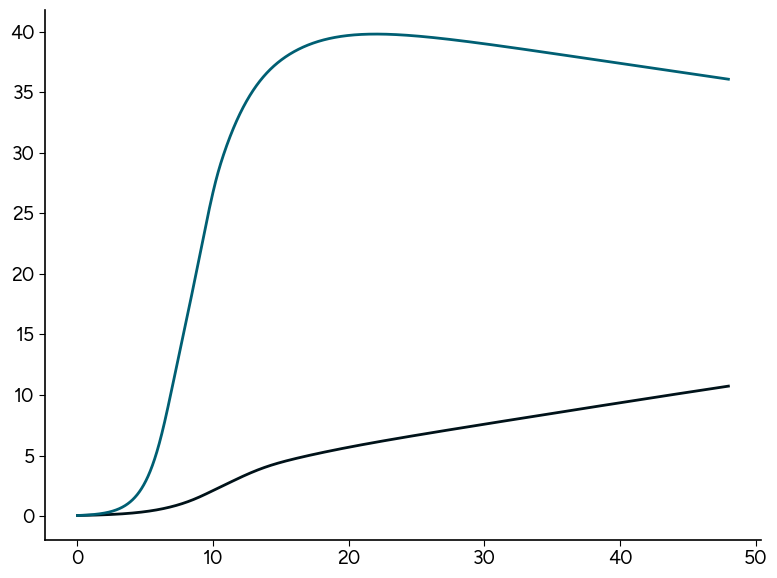

In [171]:
plt.plot(chemostat_sol.t,chemostat_sol.y[:Ns].T)

# plt.yscale("log")
plt.show()

In [172]:
qssCvsT = np.zeros((len(chemostat_sol.t),Nr))
for i in range(len(chemostat_sol.t)):
    curPop = chemostat_sol.y[:Ns,i]
    curRes = chemostat_sol.y[Ns:,i]
    currQssSol = cmpfns.qssResourcesSolver(cmpfns.resUsage,curPop,muMatrix, kMatrix, delta, supplyVec,Nr,Ns)
    qssCvsT[i] = currQssSol

tdepGrowth,tdepInter = np.zeros((len(chemostat_sol.t),Ns)),np.zeros((len(chemostat_sol.t),Ns,Ns))

for i in range(len(chemostat_sol.t)):
    tdepGrowth[i],tdepInter[i] = cmpfns.glvParamsFn(muMatrix,kMatrix,qssCvsT[i],delta,supplyVec,Nr,Ns)

KeyboardInterrupt: 

Text(0, 0.5, 'Interaction strength')

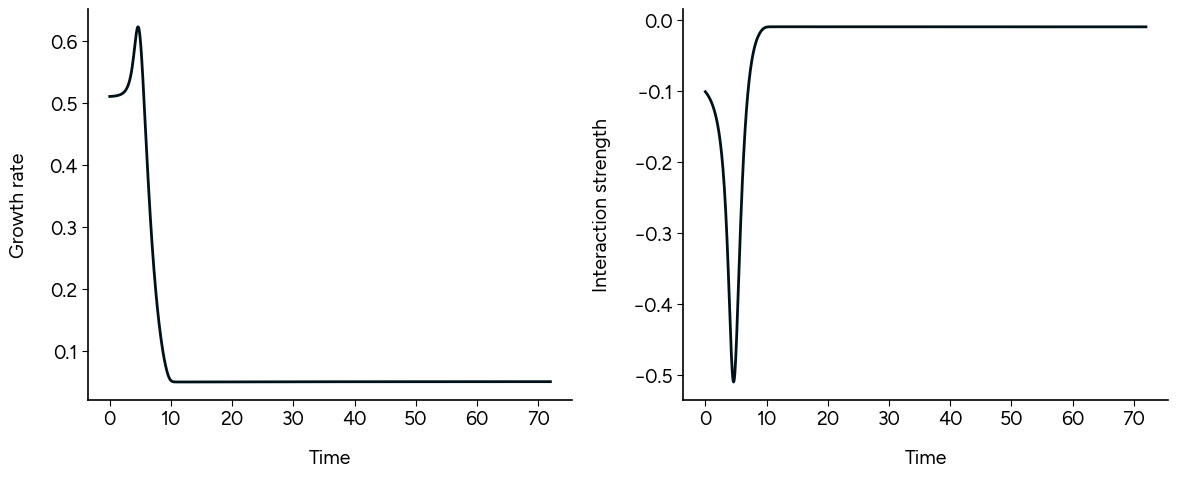

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(chemostat_sol.t,tdepGrowth)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Growth rate")

ax[1].plot(chemostat_sol.t,-tdepInter[:,0])
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Interaction strength")

In [ ]:
glv_soln = cmpfns.solveTimeDepGLV(initialPopulations,t,tdepGrowth,tdepInter)

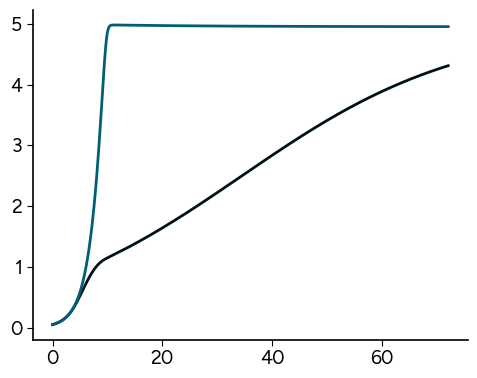

In [ ]:
fig,ax = plt.subplots(figsize=(5,4))
ax.plot(t,glv_soln.T)
ax.plot(t,chemostat_sol.y[:Ns].T)
plt.show()

## Multiple species Multiple resources

In [269]:
Nr = 40
Ns = 8

In [270]:
unscaledMuMatrix = np.random.lognormal(-1.95,1,(Ns,Nr))
muMatrix =  np.round(unscaledMuMatrix / np.max(unscaledMuMatrix) *0.6,3)

kMatrix = np.round(np.random.lognormal(5.5, 1.2,(Ns,Nr))/10,3)

supplyVec = np.full(Nr,5)
delta = 0.05

cmpfns.assertParams(muMatrix,kMatrix,delta,supplyVec,Ns=Ns,Nr=Nr)
rVecBeginning = supplyVec.copy()

In [271]:
initialPopulations = np.full(Ns,0.05)
initialResources = supplyVec
initialConditions = np.concatenate((initialPopulations,initialResources))

t = np.linspace(0,480,1000)

In [272]:
chemostat_sol = integrate.solve_ivp(cmpfns.chemostat_dynamics,(0,t[-1]),initialConditions,args=(muMatrix, kMatrix, delta, supplyVec,Nr,Ns),t_eval=t,max_step=0.1)

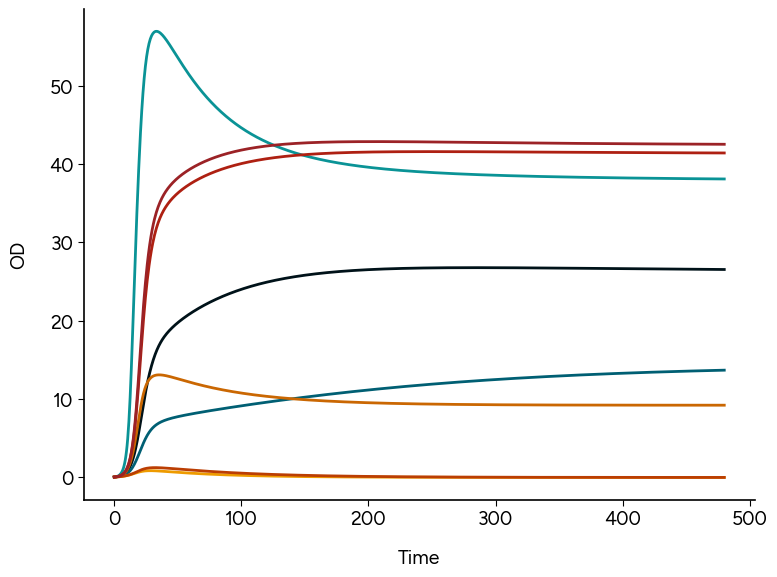

In [285]:
plt.plot(chemostat_sol.t,chemostat_sol.y[:Ns].T)

# plt.yscale("log",base=10)
plt.ylabel("OD")
plt.xlabel("Time")
plt.show()

In [279]:
qssCvsT = np.zeros((len(chemostat_sol.t),Nr))
for i in range(len(chemostat_sol.t)):
    curPop = chemostat_sol.y[:Ns,i]
    curRes = chemostat_sol.y[Ns:,i]
    currQssSol = cmpfns.qssResourcesSolver(cmpfns.resUsage,curPop,curRes,muMatrix, kMatrix, delta, supplyVec,Nr,Ns)
    qssCvsT[i] = currQssSol

tdepGrowth,tdepInter = np.zeros((len(chemostat_sol.t),Ns)),np.zeros((len(chemostat_sol.t),Ns,Ns))

for i in range(len(chemostat_sol.t)):
    tdepGrowth[i],tdepInter[i] = cmpfns.glvParamsFn(muMatrix,kMatrix,qssCvsT[i],delta,supplyVec,Nr,Ns)

In [280]:
# # Plotting QSS and chemostat resource concentrations

# fig,ax = plt.subplots(figsize=(8,6))
# for i in range(Nr):
#     ax.plot(chemostat_sol.t,qssCvsT[:,i],ls = "--",color=f"C{i}")
#     ax.plot(chemostat_sol.t,chemostat_sol.y[Ns+i],color=f"C{i}")
# plt.show()

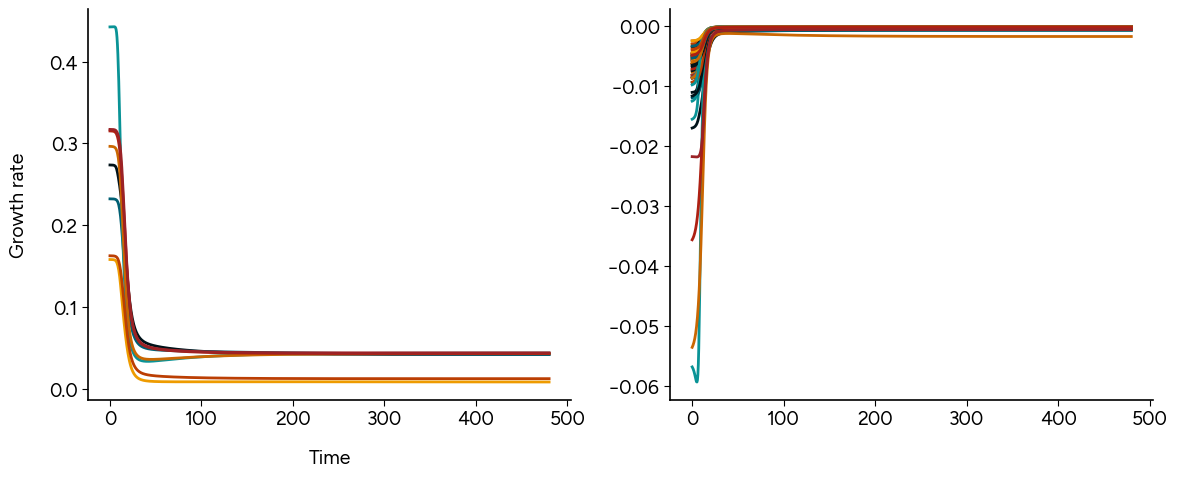

In [281]:
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(chemostat_sol.t,tdepGrowth)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Growth rate")

ax[1].plot(chemostat_sol.t,-tdepInter.reshape(len(chemostat_sol.t),Ns*Ns))
# ax[1].set_xlabel("Time")
# ax[1].set_ylabel("Interaction strength")
plt.show()

In [282]:
glv_soln_context_dep = cmpfns.solveTimeDepGLV(initialPopulations,t,tdepGrowth,tdepInter)
glv_soln_final_interactions = cmpfns.solveGLV(initialPopulations,t,tdepGrowth[-1],tdepInter[-1])

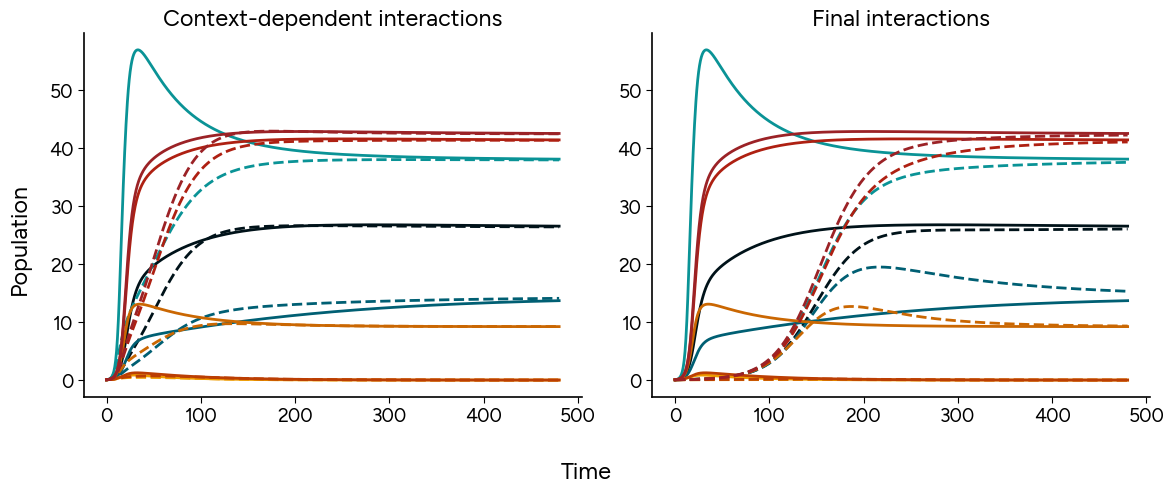

In [283]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
for i in range(Ns):
    ax[0].plot(t,glv_soln_context_dep[i],ls="--",color=f"C{i}")
    ax[0].plot(t,chemostat_sol.y[i],color=f"C{i}")
    ax[1].plot(t,glv_soln_final_interactions[i],ls="--",color=f"C{i}")
    ax[1].plot(t,chemostat_sol.y[i],color=f"C{i}")
# ax[0].set_yscale("log")
# ax[1].set_yscale("log")

ax[0].set_title("Context-dependent interactions")
ax[1].set_title("Final interactions")

fig.supxlabel("Time")
fig.supylabel("Population")

plt.show()

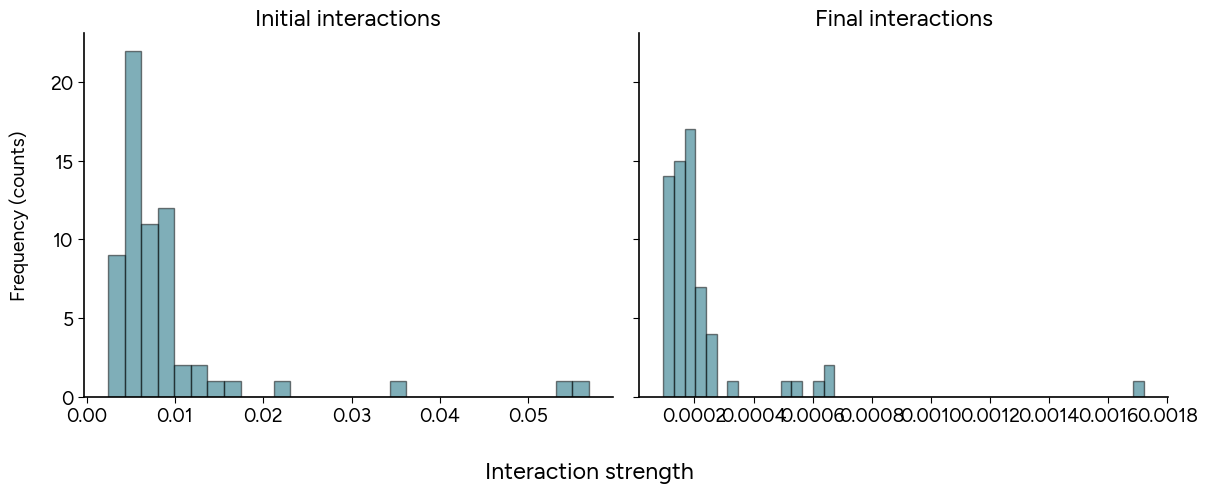

In [284]:
fig,ax = plt.subplots(1,2,figsize=(12,5),sharey=True)

ax[0].hist(tdepInter[0].flatten(),bins="auto",density=False,facecolor="C1",alpha=0.5,edgecolor="black")
ax[0].set_title("Initial interactions")
ax[1].hist(tdepInter[-1].flatten(),bins="auto",density=False,facecolor="C1",alpha=0.5,edgecolor="black")
ax[1].set_title("Final interactions")

ax[0].set_ylabel("Frequency (counts)")

fig.supxlabel("Interaction strength")
plt.show()


In [286]:
qssCBegin = cmpfns.qssResourcesSolver(cmpfns.resUsage,initialPopulations,initialResources,muMatrix, kMatrix, delta, supplyVec,Nr,Ns)
qssCEnd = cmpfns.qssResourcesSolver(cmpfns.resUsage,chemostat_sol.y[:Ns,-1],chemostat_sol.y[Ns:,-1],muMatrix, kMatrix, delta, supplyVec,Nr,Ns)

tdepGrowthBegin,tdepInterBegin = cmpfns.glvParamsFn(muMatrix,kMatrix,qssCBegin,delta,supplyVec,Nr,Ns)
tdepGrowthEnd,tdepInterEnd = cmpfns.glvParamsFn(muMatrix,kMatrix,qssCEnd,delta,supplyVec,Nr,Ns)

In [287]:
histbegin,edgesbegin = np.histogram(tdepInterBegin.flatten(),bins="auto",density=False)
histend,edgesend = np.histogram(tdepInterEnd.flatten(),bins="auto",density=False)

cumhistbegin = 1- np.cumsum(histbegin)/np.sum(histbegin)
cumhistend = 1-np.cumsum(histend)/np.sum(histend)

In [288]:
fitbegin = optimize.curve_fit(gamma_ccdf,edgesbegin[:-1],cumhistbegin)
fitend = optimize.curve_fit(gamma_ccdf,edgesend[:-1],cumhistend)

In [289]:
fitend[0]

array([3.45985325e+00, 4.32913125e-05])

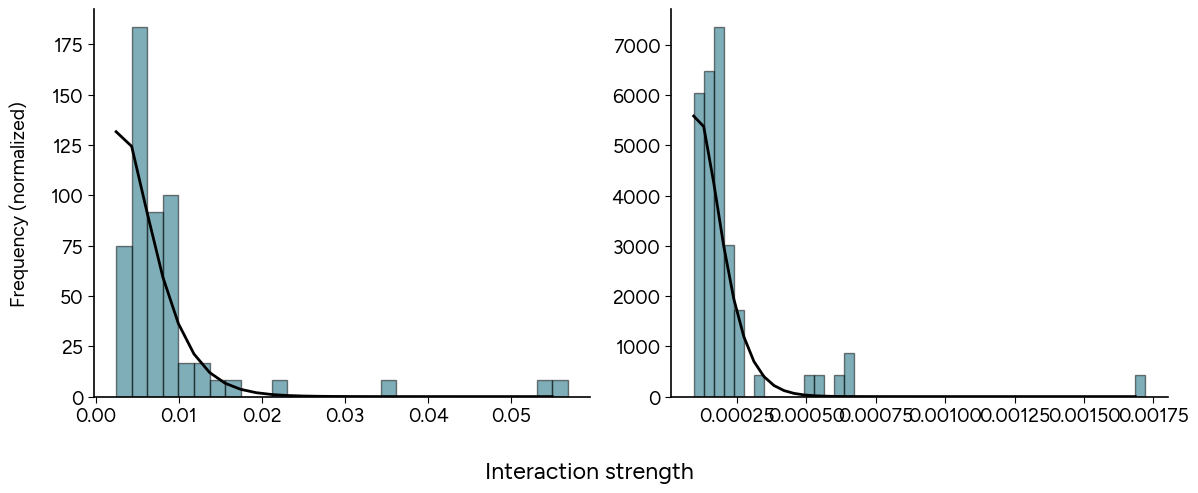

In [290]:
fig,ax = plt.subplots(1,2,figsize=(12,5),sharey=False)

ax[0].hist(tdepInterBegin.flatten(),bins="auto",density=True,facecolor="C1",alpha=0.5,edgecolor="black")
ax[0].plot(edgesbegin[:-1],gamma_fn(edgesbegin[:-1],*fitbegin[0]),color="black")
ax[1].hist((tdepInterEnd).flatten(),bins="auto",density=True,facecolor="C1",alpha=0.5,edgecolor="black")
ax[1].plot(edgesend[:-1],gamma_fn(edgesend[:-1],*fitend[0]),color="black")

ax[0].set_ylabel("Frequency (normalized)")

fig.supxlabel("Interaction strength")
plt.show()


In [291]:
fitend[0]

array([3.45985325e+00, 4.32913125e-05])

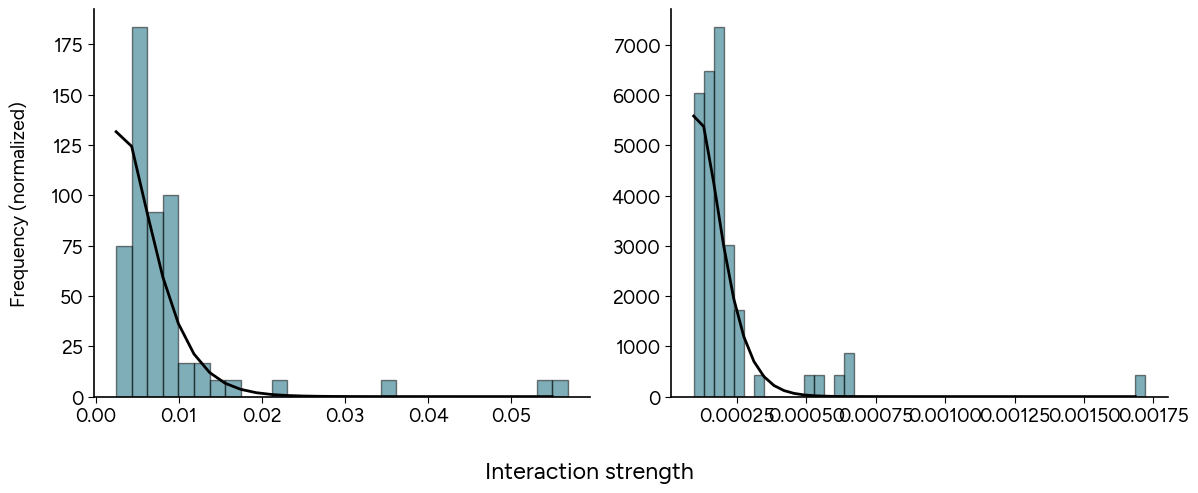

In [292]:
fig,ax = plt.subplots(1,2,figsize=(12,5),sharey=False)

ax[0].hist(tdepInterBegin.flatten(),bins="auto",density=True,facecolor="C1",alpha=0.5,edgecolor="black")
ax[0].plot(edgesbegin[:-1],gamma_fn(edgesbegin[:-1],*fitbegin[0]),color="black")
ax[1].hist((tdepInterEnd).flatten(),bins="auto",density=True,facecolor="C1",alpha=0.5,edgecolor="black")
ax[1].plot(edgesend[:-1],gamma_fn(edgesend[:-1],*fitend[0]),color="black")

ax[0].set_ylabel("Frequency (normalized)")

fig.supxlabel("Interaction strength")
plt.show()


## Variance of parameters and scaling with number of species

In [66]:
Nr = 40
Ns = 8

muMean,muSd = -1.95,1
kMean,kSd = 5.5,1.2

delta = 0.05
supplyVec = np.full(Nr,5)

In [76]:
numRuns = 1000

In [78]:
TSTART = time.time()
muMatrices,kMatrices,tdepGrowths,tdepInters,fitResults,fitErrors,chemostatSolutions = competitive_scaling.multipleRun(Nr,Ns,supplyVec,delta,muMean,muSd,kMean,kSd,numRuns)
print(time.time()-TSTART)

c:\Users\ppraj\Dropbox\PhD\Code\OE-dilutions\notebooks\../scripts\competitive_scaling.py:43: OptimizeWarning: Covariance of the parameters could not be estimated
  fitend = optimize.curve_fit(gamma_ccdf,edgesend[:-1],cumhistend)


5106.201926469803


In [148]:
singleRunData = {"muMatrices":muMatrices,"kMatrices":kMatrices,"tdepGrowths":tdepGrowths,"tdepInters":tdepInters,"fitResults":fitResults,"fitErrors":fitErrors,"chemostatSolutions":chemostatSolutions}

In [150]:
# save_compressed_pickle("../data/singleRunData_Ns-8_Nr-40",singleRunData)

In [299]:
varianceErrors = np.zeros((1000,2))
for i in range(1000):
    varianceErrors[i] = singleRunData['fitErrors'][i][0,0],singleRunData['fitErrors'][i][1,1]

print(np.max(varianceErrors))
print(np.mean(fitResults[:,0]),np.std(fitResults[:,0]))
print(np.mean(fitResults[:,1]),np.std(fitResults[:,1]))

inf
17.673730039153714 0.0
1.235674991242128e-06 0.0


In [ ]:
np.isfinite

In [315]:
redVarErr = varianceErrors[:,0][np.isfinite(varianceErrors[:,0])]

In [327]:
logbins = np.geomspace(np.min(redVarErr),np.max(redVarErr),80)
histvar,edgesvar = np.histogram(redVarErr,bins=logbins,density=False)

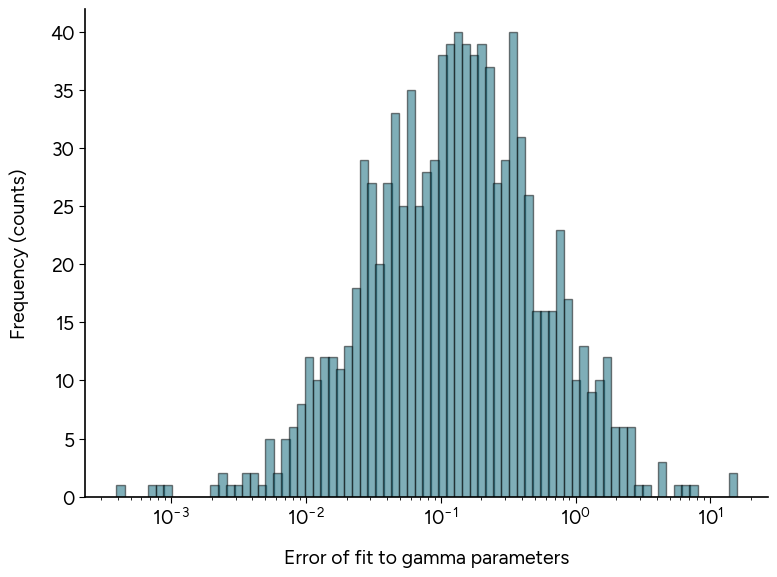

In [333]:
plt.bar(edgesvar[:-1],histvar,width=np.diff(edgesvar),edgecolor="black",alpha=0.5,facecolor="C1")
plt.xscale("log")
plt.xlabel("Error of fit to gamma parameters")
plt.ylabel("Frequency (counts)")
plt.show()

In [80]:
def scalingSpecies(Nr,Ns,supplyVec,delta,muMean,muSd,kMean,kSd,numRuns):
    muMatrices,kMatrices,tdepGrowths,tdepInters,fitResults,fitErrors,chemostatSolutions = competitive_scaling.multipleRun(Nr,Ns,supplyVec,delta,muMean,muSd,kMean,kSd,numRuns)
    return muMatrices,kMatrices,tdepGrowths,tdepInters,fitResults,fitErrors,chemostatSolutions

In [455]:
NsList = np.array([2,4,8,10,20,30,40,60])
NrList = NsList*4

muMean,muSd = -1.95,1
kMean,kSd = 5.5,1.2

delta = 0.05

numRuns = 50

In [393]:
TSTARTTOTAL = time.time()
functionResults = []
for i in range(len(NsList)):
    TSTART = time.time()
    supplyVec = np.full(NrList[i],5)
    functionResults.append(competitive_scaling.multipleRun(NrList[i],NsList[i],supplyVec,delta,muMean,muSd,kMean,kSd,numRuns))
    print(f"Finished {i+1}/{len(NsList)} in {time.time()-TSTART} seconds")
print(f"Total time: {time.time()-TSTARTTOTAL}")

KeyboardInterrupt: 

In [454]:
# save_compressed_pickle("../data/scalingSpeciesData",functionResults)

# functionResults = load_compressed_pickle("../data/scalingSpeciesData")

In [369]:
mulSpFitParams = np.zeros((len(NsList),numRuns,2))

for i in range(len(NsList)):
    for j in range(numRuns):
        mulSpFitParams[i,j] = functionResults[i][4][j]

In [370]:
# plt.plot(NsList,np.mean(mulSpFitParams[:,:,0],axis=1),marker="o")
# plt.errorbar(NsList,np.mean(mulSpFitParams[:,:,0],axis=1),yerr=np.std(mulSpFitParams[:,:,0],axis=1),fmt="o")
# # # plt.xscale("log")
# # plt.yscale("log")
# plt.show()

In [371]:
# plt.plot(NsList,np.mean(mulSpFitParams[:,:,1],axis=1),marker="o")
# plt.errorbar(NsList,np.mean(mulSpFitParams[:,:,1],axis=1),yerr=np.std(mulSpFitParams[:,:,1],axis=1),ls="none")
# plt.yscale("log")
# plt.xscale("log")
# plt.show()

In [372]:
def straightLine(x,m,c):
    return m*x + c

In [373]:
optimize.curve_fit(straightLine,np.log(NsList),np.log(np.mean(mulSpFitParams[:,:,1],axis=1)))

(array([-2.04003838, -4.67947883]),
 array([[ 0.01187098, -0.03062954],
        [-0.03062954,  0.09339834]]))

In [374]:
meansInter,sdsInter,thirdCumulant = np.zeros(len(NsList)),np.zeros(len(NsList)),np.zeros(len(NsList))
meanerrInter,sderrInter,errThridInter = np.zeros(len(NsList)),np.zeros(len(NsList)),np.zeros(len(NsList))


for i in range(len(NsList)):
    tdepinter = functionResults[i][3]
    numRunsMeans = np.mean(tdepinter,axis=(1,2))
    numRunsSds = np.std(tdepinter,axis=(1,2))
    numRunsThirds = np.mean(tdepinter**3,axis=(1,2)) - 3*numRunsMeans*numRunsSds**2 - numRunsMeans**3
    meansInter[i] = np.mean(numRunsMeans)
    sdsInter[i] = np.mean(numRunsSds)
    meanerrInter[i] = np.std(numRunsMeans)
    sderrInter[i] = np.std(numRunsSds)
    thirdCumulant[i] = np.mean(numRunsThirds)
    errThridInter[i] = np.std(numRunsThirds)



In [375]:
meanFit = optimize.curve_fit(straightLine,np.log(NsList),np.log(meansInter))
sdFit = optimize.curve_fit(straightLine,np.log(NsList),np.log(sdsInter))
thirdCumFit = optimize.curve_fit(straightLine,np.log(NsList),np.log(thirdCumulant))

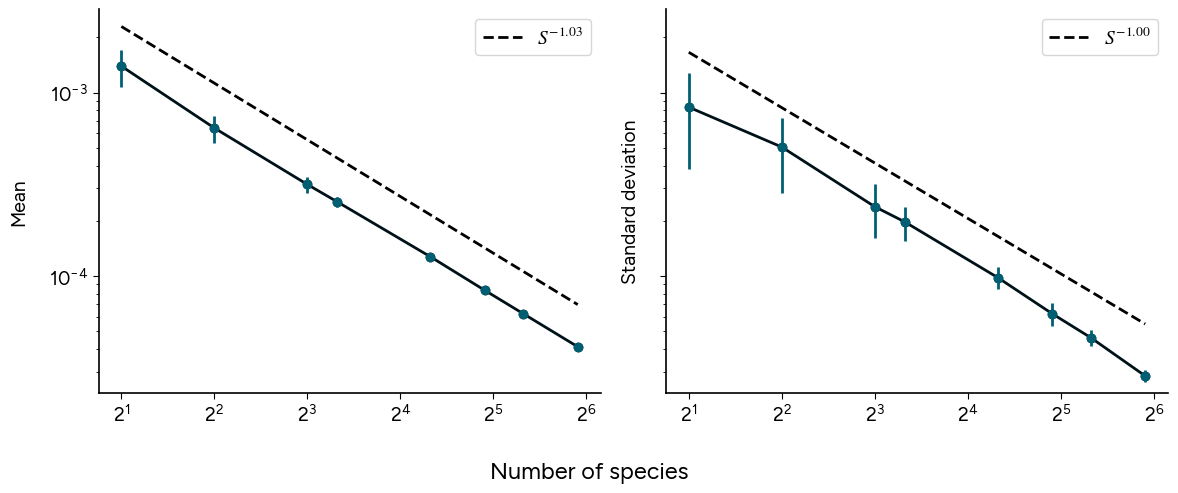

In [492]:
fig,ax = plt.subplots(1,2,figsize=(12,5),sharey=True)

ax[0].plot(NsList,meansInter,marker="o")
ax[0].errorbar(NsList,meansInter,yerr=meanerrInter,fmt="o")
ax[0].plot(NsList,np.exp(meanFit[0][1]/1.1)*NsList**meanFit[0][0],color="black",ls="--",label=r"$S^{%.2f}$"%meanFit[0][0])
ax[0].set_yscale("log")
ax[0].set_xscale("log",base=2)
ax[0].set_ylabel("Mean")
ax[0].legend()

ax[1].plot(NsList,sdsInter,marker="o")
ax[1].errorbar(NsList,sdsInter,yerr=sderrInter,fmt="o")
ax[1].plot(NsList,np.exp(sdFit[0][1]/1.1)*NsList**sdFit[0][0],color="black",ls="--",label=r"$S^{%.2f}$"%sdFit[0][0])
ax[1].set_yscale("log")
ax[1].set_xscale("log",base=2)
ax[1].set_ylabel("Standard deviation")
ax[1].legend()

fig.supxlabel("Number of species")

plt.show()

In [359]:
# plt.plot(NsList,thirdCumulant,marker="o")
# plt.errorbar(NsList,thirdCumulant,yerr=errThridInter,fmt="o")
# plt.plot(NsList,np.exp(thirdCumFit[0][1]/1.1)*NsList**thirdCumFit[0][0],color="black",ls="--",label=r"$S^{%.2f}$"%thirdCumFit[0][0])
# plt.yscale("log")
# plt.xscale("log")
# plt.legend()
# plt.ylabel("Third cumulant")

### Checking for GLV error and final species abundabce

In [412]:
Nr = 400
Ns = 100

muMean,muSd = -1.95,1
kMean,kSd = 5.5,1.2

delta = 0.05
supplyVec = np.full(Nr,5)

In [413]:
numRuns = 1

In [239]:
TSTART = time.time()
muMatrices,kMatrices,tdepGrowths,tdepInters,fitResults,fitErrors,chemostatSolutions,glvErr = competitive_scaling.multipleRun(Nr,Ns,supplyVec,delta,muMean,muSd,kMean,kSd,numRuns)
print(time.time()-TSTART)

2997.7061240673065


In [414]:
curInitPop = np.full(Ns,0.05)
curInitRes = np.full(Nr,5)
curSupply = np.full(Nr,5)
cutInitCond = np.concatenate((curInitPop,curInitRes))
curNr,curNs = Nr,Ns
t = np.linspace(0,1000,1000)

In [415]:
curChemostatSol = integrate.solve_ivp(cmpfns.chemostat_dynamics,(0,t[-1]),cutInitCond,args=(muMatrices[0], kMatrices[0], delta, supplyVec,curNr,curNs),t_eval=t,max_step=0.1)
curGLVsol = cmpfns.solveGLV(curInitPop,t,tdepGrowths[0],tdepInters[0])

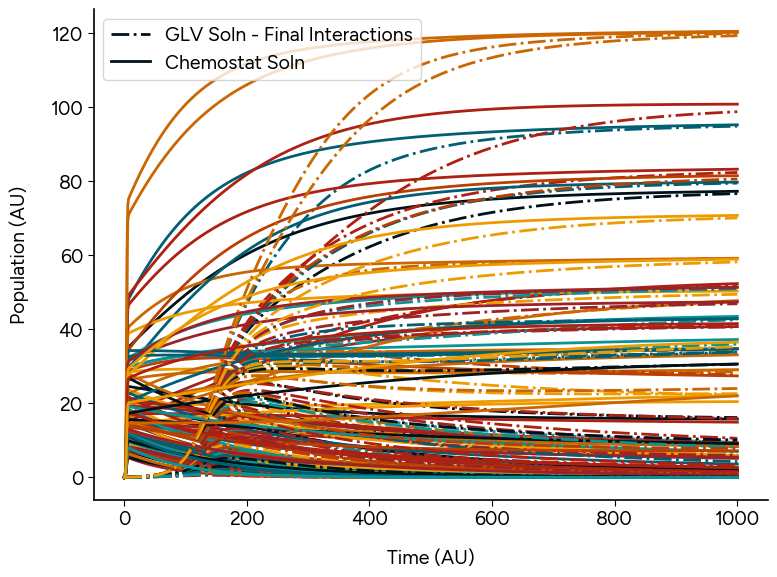

In [421]:
for i in range(curNs):
    if(i==0):
        plt.plot(t,curGLVsol[i],color=f"C{i}",ls="-.",label="GLV Soln - Final Interactions")
        # plt.axhline(functionResults[-1][-2][:,:NsList[-1]][33][i],color=f"C{i}",ls="--")
        plt.plot(t,curChemostatSol.y[i],color=f"C{i}",label="Chemostat Soln")	
    else:
        plt.plot(t,curGLVsol[i],color=f"C{i}",ls="-.")
        plt.plot(t,curChemostatSol.y[i],color=f"C{i}")

plt.legend()
# plt.yscale("log")
plt.xlabel("Time (AU)")
plt.ylabel("Population (AU)")
plt.show()

In [427]:
np.where(glvErr == np.min(glvErr))

(array([0], dtype=int64), array([62], dtype=int64))

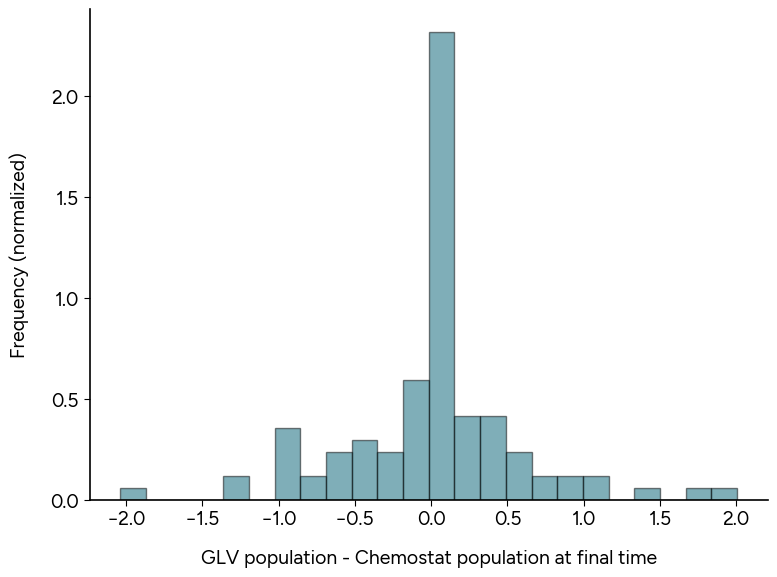

In [429]:
plt.hist(glvErr.flatten(),bins="auto",density=True,facecolor="C1",alpha=0.5,edgecolor="black")
plt.xlabel("GLV population - Chemostat population at final time")
plt.ylabel("Frequency (normalized)")
plt.show()

In [435]:
logbins = np.geomspace(np.min(chemostatSolutions[0,:Ns]),np.max(chemostatSolutions[0,:Ns]),20)

In [451]:
hist,edges = np.histogram(chemostatSolutions[0,:Ns],bins=logbins,density=False)

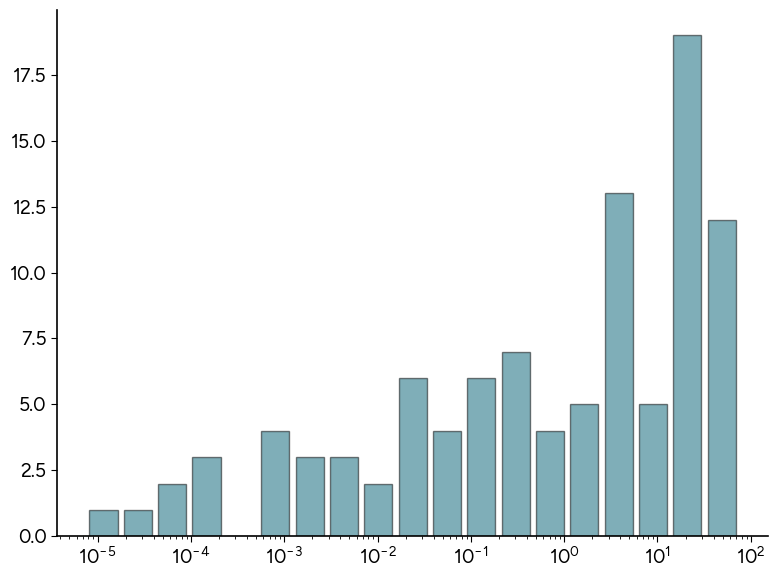

In [453]:
plt.bar(edges[:-1],hist,width=np.diff(edges)*0.5,edgecolor="black",alpha=0.5,facecolor="C1")
plt.xscale("log")
# plt.yscale("log")

plt.show()

### Scaling with survived number of species

In [457]:
NsList = np.array([2,4,8,10,20,30,40,60])
NrList = NsList*4

muMean,muSd = -1.95,1
kMean,kSd = 5.5,1.2

delta = 0.05

numRuns = 50

In [458]:
# save_compressed_pickle("../data/scalingSpeciesData",functionResults)
# functionResults = load_compressed_pickle("../data/scalingSpeciesData")

In [472]:
survivedSpeciesList = []
shannonDiversityList = []

for i in range(NsList.size):
    curSurvivedSpecies = np.zeros(numRuns)
    curShannonDiversity = np.zeros(numRuns)
    for j in range(numRuns):
        curSurvivedSpecies[j] = np.sum(functionResults[i][6][j][:NsList[i]]>1)
        curShannonDiversity[j] = np.sum(functionResults[i][6][j][:NsList[i]]*np.log(functionResults[i][6][j][:NsList[i]]))
    survivedSpeciesList.append(curSurvivedSpecies)
    shannonDiversityList.append(curShannonDiversity)

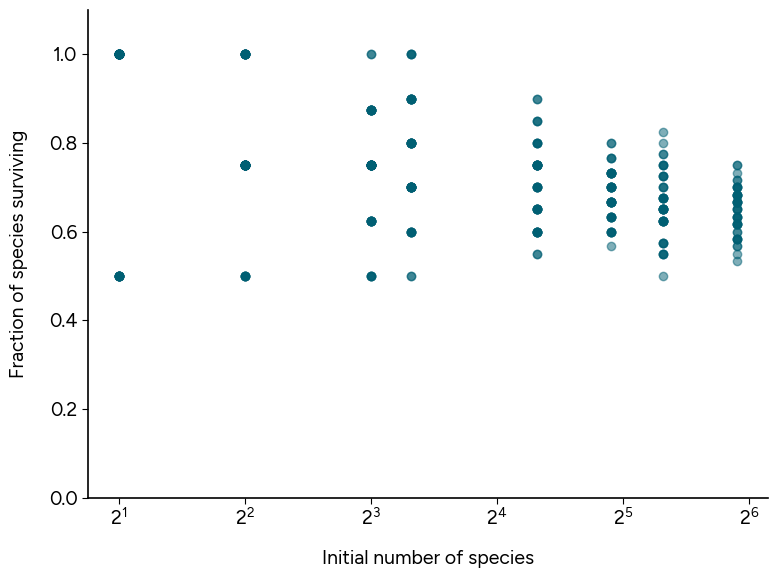

In [502]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

for i in range(NsList.size):
    ax.scatter(np.full(numRuns,NsList[i]),survivedSpeciesList[i]/NsList[i],color="C1",alpha=0.5)
# ax.plot(NsList,NrList,color="black",ls="--",label="Competetive Exclusion")
# ax.plot(NsList,NsList/2,color="#d62828",label="Expected number of species surviving")
ax.set_xlabel("Initial number of species")
ax.set_ylabel("Fraction of species surviving")
ax.set_ylim(0,1.1)
ax.set_xscale("log",base=2)
# ax.legend()

plt.show()

### Varying number of resources

In [507]:
NrList = np.array([2,4,8,16,32,64,128])
NsList = np.full(NrList.size,10)

muMean,muSd = -1.95,1
kMean,kSd = 5.5,1.2

delta = 0.05

numRuns = 10

In [505]:
TSTARTTOTAL = time.time()
functionResults_res = []
for i in range(len(NrList)):
    TSTART = time.time()
    supplyVec = np.full(NrList[i],5)
    functionResults_res.append(competitive_scaling.multipleRun(NrList[i],NsList[i],supplyVec,delta,muMean,muSd,kMean,kSd,numRuns))
    print(f"Finished {i+1}/{len(NsList)} in {time.time()-TSTART} seconds")
print(f"Total time: {time.time()-TSTARTTOTAL}")

Finished 1/7 in 5.347635507583618 seconds
Finished 2/7 in 5.508503675460815 seconds
Finished 3/7 in 5.4914391040802 seconds
Finished 4/7 in 5.384215831756592 seconds
Finished 5/7 in 5.562066316604614 seconds
Finished 6/7 in 7.227398872375488 seconds
Finished 7/7 in 16.192503929138184 seconds
Total time: 50.71376323699951


In [509]:
meansInter,sdsInter,thirdCumulant = np.zeros(len(NrList)),np.zeros(len(NrList)),np.zeros(len(NrList))
meanerrInter,sderrInter,errThridInter = np.zeros(len(NrList)),np.zeros(len(NrList)),np.zeros(len(NrList))


for i in range(len(NrList)):
    tdepinter = functionResults_res[i][3]
    numRunsMeans = np.mean(tdepinter,axis=(1,2))
    numRunsSds = np.std(tdepinter,axis=(1,2))
    numRunsThirds = np.mean(tdepinter**3,axis=(1,2)) - 3*numRunsMeans*numRunsSds**2 - numRunsMeans**3
    meansInter[i] = np.mean(numRunsMeans)
    sdsInter[i] = np.mean(numRunsSds)
    meanerrInter[i] = np.std(numRunsMeans)
    sderrInter[i] = np.std(numRunsSds)
    thirdCumulant[i] = np.mean(numRunsThirds)
    errThridInter[i] = np.std(numRunsThirds)



In [510]:
meanFit = optimize.curve_fit(straightLine,np.log(NrList),np.log(meansInter))
sdFit = optimize.curve_fit(straightLine,np.log(NrList),np.log(sdsInter))
thirdCumFit = optimize.curve_fit(straightLine,np.log(NrList),np.log(thirdCumulant))

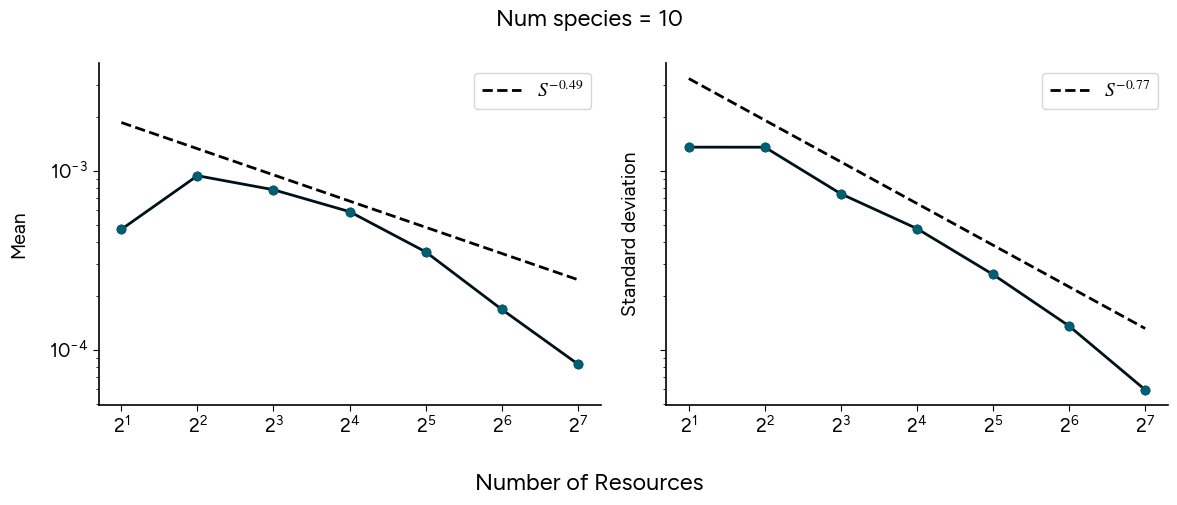

In [514]:
fig,ax = plt.subplots(1,2,figsize=(12,5),sharey=True)

ax[0].plot(NrList,meansInter,marker="o")
ax[0].errorbar(NrList,meansInter,yerr=meanerrInter,fmt="o")
ax[0].plot(NrList,np.exp(meanFit[0][1]/1.1)*NrList**meanFit[0][0],color="black",ls="--",label=r"$S^{%.2f}$"%meanFit[0][0])
ax[0].set_yscale("log")
ax[0].set_xscale("log",base=2)
ax[0].set_ylabel("Mean")
ax[0].legend()

ax[1].plot(NrList,sdsInter,marker="o")
ax[1].errorbar(NrList,sdsInter,yerr=sderrInter,fmt="o")
ax[1].plot(NrList,np.exp(sdFit[0][1]/1.1)*NrList**sdFit[0][0],color="black",ls="--",label=r"$S^{%.2f}$"%sdFit[0][0])
ax[1].set_yscale("log")
ax[1].set_xscale("log",base=2)
ax[1].set_ylabel("Standard deviation")
ax[1].legend()

fig.supxlabel("Number of Resources")
fig.suptitle("Num species = 10")

plt.show()